## Advanced Lane Lines Project

### 1. Camera Calibration

There are two types of distortion that can be introduced by a camera:
1. Radial distortion: light bends a little TOO MUCH or TOO LITTLE at the edge of lenses.
2. Tangential distortion: camera's lense is not aligned perfectly parallel to the imaging plane.

In order to correct distortion, we need to calculate the correct camera matrix and distortion coefficients. This can be done by using the calibration chessboard (9x6) images.

After the matrix and coeeficients are calculated, we gonna use them to undistort an image to demonstrate their correctness. 

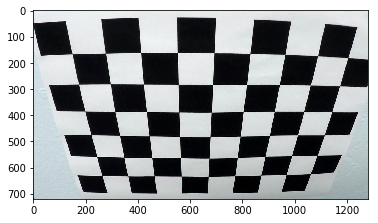

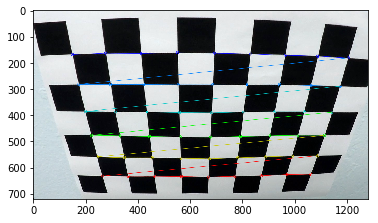

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

nx = 9
ny = 6

# Read in an image
file = './camera_cal/calibration2.jpg'
image = cv2.imread(file)
plt.imshow(image)
plt.show()

# Find the corners in the chessboard
ret, corners = cv2.findChessboardCorners(image, (nx, ny), None)
if ret:
    # If found, draw chessboard corners
    out = cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
    plt.imshow(out)
    plt.show()

Read all calibration images, calculate matrix and distortion coefficients and display the undistortion images.

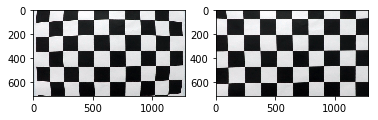

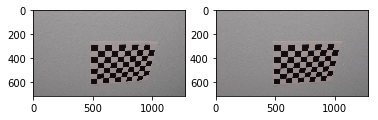

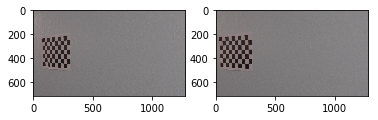

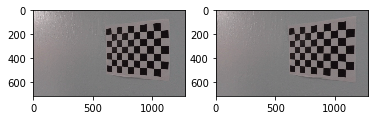

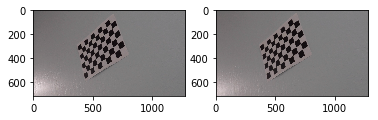

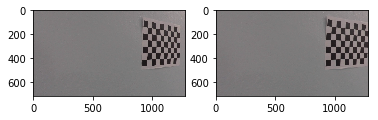

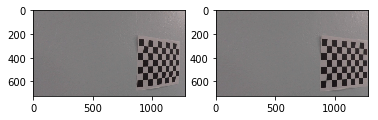

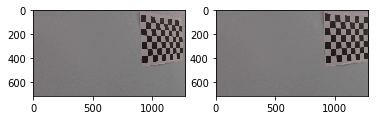

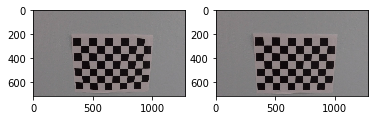

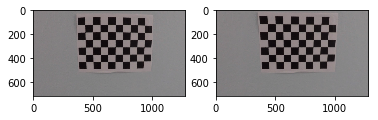

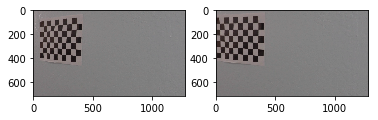

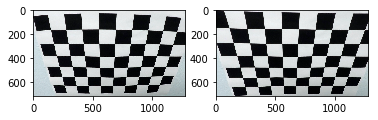

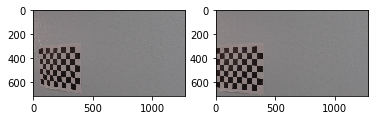

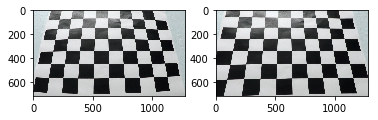

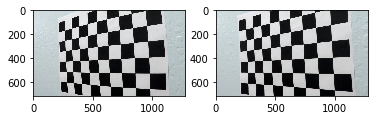

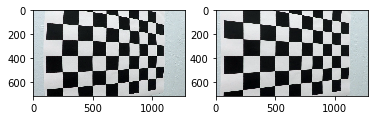

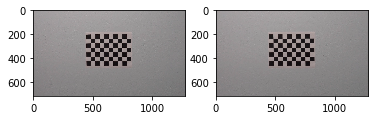

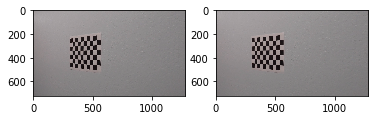

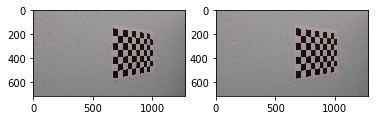

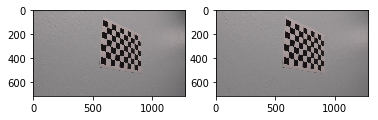

In [17]:
import glob

nx = 9
ny = 6

objpoints = []
imgpoints = []

# Generate object point
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) # x,y coordinates

files = glob.glob('./camera_cal/calibration*.jpg')

for file in files:
    image = cv2.imread(file)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

# Calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape[0:2], None, None)
for file in files:
    image = cv2.imread(file)
    undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(image)
    fig.add_subplot(1,2,2)
    plt.imshow(undistort_img)
    plt.show()

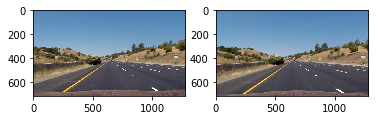

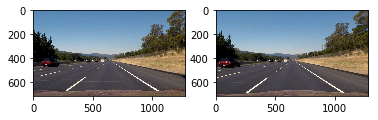

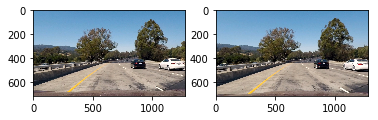

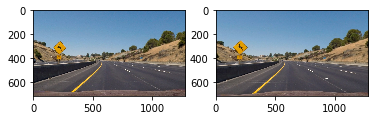

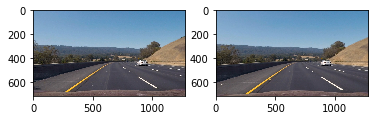

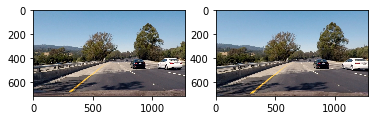

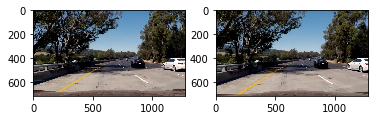

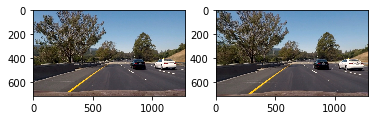

In [86]:
# Apply matrix to test images

images = []
files = glob.glob('./test_images/*.jpg')
for file in files:
    image = mpimg.imread(file)
    undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(image)
    fig.add_subplot(1,2,2)
    plt.imshow(undistort_img)
    plt.show()
    images.append(undistort_img)

### 2. Create Threshold Binary Images

Use various technologies (e.g. color space transforms and Sobel gradients) to create binary images containing lane pixels.

#### 2.1 Color selection

Firstly, let's take an image and compare the performance of each channel in HLS and HSV color space:

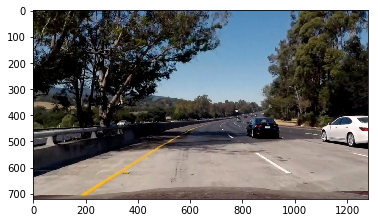

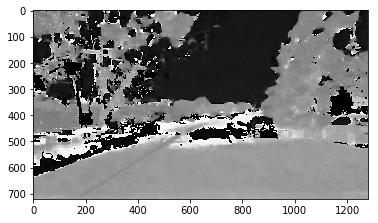

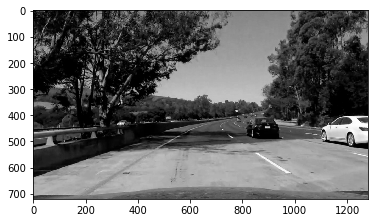

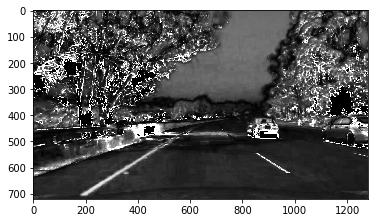

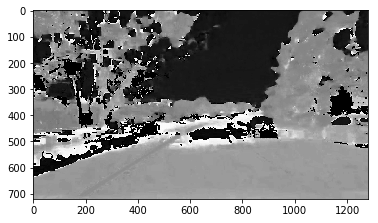

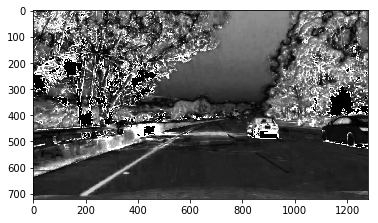

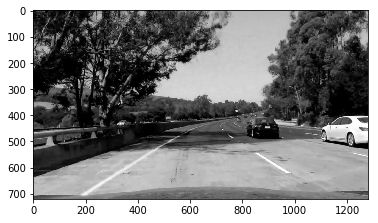

In [19]:
img = images[6]

plt.imshow(img)
plt.show()

hls_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
for i in range(3):
    plt.imshow(hls_img[:,:,i], cmap='gray')
    plt.show()
    
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
for i in range(3):
    plt.imshow(hsv_img[:,:,i], cmap='gray')
    plt.show()

After visually checked all test images, I found S channel in HLS color space output a stable and better result. I then define a color threshold function to filter the image.

In [47]:
def color_thresh(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary = np.zeros_like(s_channel)
    binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary

#### 2.2 Gradient Selection

Now let's take a look at the gradient method. I use Sobel gradient and want to check the binary image of these 4 operations: sobel-x, sobel-y, sobel magnitude, sobel direction.

In [38]:
def abs_sobel(img, sobel_kernel=3):
    '''Apply Sobel operator to an image and return absolute value of sobel value on x and y direction'''
    if img.ndim == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    return abs_sobel_x, abs_sobel_y

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    '''Calculate sobel x and y and filter result'''
    abs_sobel_x, abs_sobel_y = abs_sobel(img, sobel_kernel)
    if orient == 'x':
        sobel = abs_sobel_x
    if orient == 'y':
        sobel = abs_sobel_y
    scaled_sobel = np.uint8(255 * sobel / np.max(sobel))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    '''Calculate gradient magnitude and filter result'''
    abs_sobel_x, abs_sobel_y = abs_sobel(img, sobel_kernel)
    gradmag = np.sqrt(abs_sobel_x**2 + abs_sobel_y**2)
    scaled_gradmag = np.uint8(255 * gradmag / np.max(gradmag))
    mag_binary = np.zeros_like(scaled_gradmag)
    mag_binary[(scaled_gradmag >= mag_thresh[0]) & (scaled_gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''Calculate gradient direction and filter result'''
    abs_sobel_x, abs_sobel_y = abs_sobel(img, sobel_kernel)
    graddir = np.arctan2(abs_sobel_y, abs_sobel_x)
    dir_binary = np.zeros_like(graddir)
    dir_binary[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1
    return dir_binary

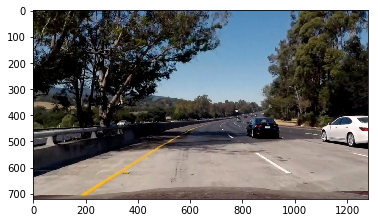

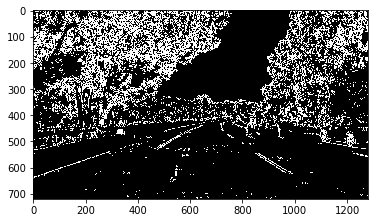

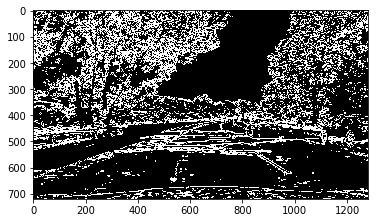

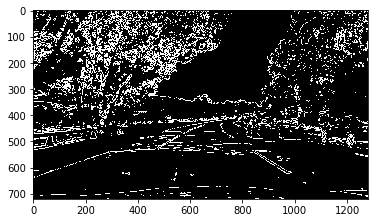

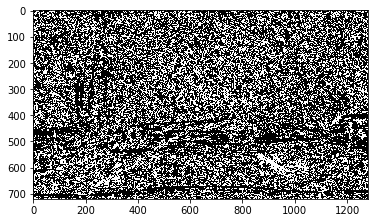

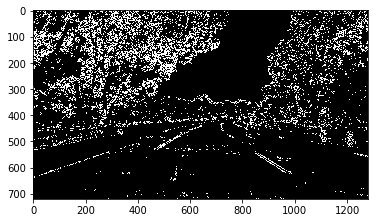

In [45]:
img = images[6]
plt.imshow(img)
plt.show()

gradx = abs_sobel_thresh(img, 'x', sobel_kernel=3, thresh=(10, 80))
plt.imshow(gradx, cmap='gray')
plt.show()

grady = abs_sobel_thresh(img, 'y', sobel_kernel=3, thresh=(10, 80))
plt.imshow(grady, cmap='gray')
plt.show()

# filter magnitude
mag_binary = mag_thresh(img, mag_thresh=(30, 100))
plt.imshow(mag_binary, cmap='gray')
plt.show()

# filter direction
dir_binary = dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3))
plt.imshow(dir_binary, cmap='gray')
plt.show()

# combine
binary = np.zeros_like(gradx)
binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(binary, cmap='gray')
plt.show()

#### 2.3 Combine Two Methods

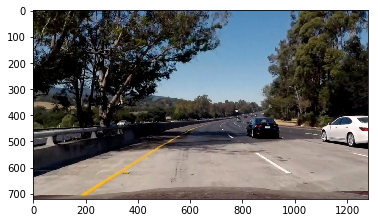

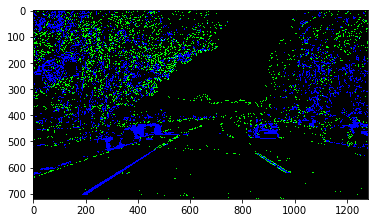

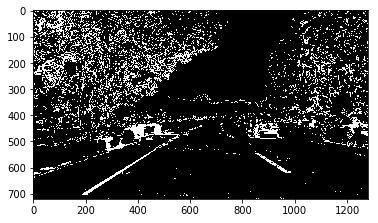

In [58]:
img = images[6]
plt.imshow(img)
plt.show()

# gradient method
gradx = abs_sobel_thresh(img, 'x', sobel_kernel=3, thresh=(30, 80))
grady = abs_sobel_thresh(img, 'y', sobel_kernel=3, thresh=(30, 80))
mag_binary = mag_thresh(img, mag_thresh=(30, 100))
dir_binary = dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3))

grad = np.zeros_like(gradx)
grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Color selection
color = color_thresh(img, thresh=(170, 255))

# Combine
stack_binary = np.dstack((np.zeros_like(grad), grad*255, color*255))
plt.imshow(stack_binary)
plt.show()

out = np.zeros_like(gradx)
out[(grad == 1) | (color == 1)] = 1
plt.imshow(out, cmap = 'gray')
plt.show()

It's evident that by combining both the color selection and gradient filter method, the output binary image can reserve most of the lane pixels under various of circumstances! Now let's apply these filters to all test images.

In [62]:
def cvt_binary_img(img):
    # gradient method
    gradx = abs_sobel_thresh(img, 'x', thresh=(30, 80))
    grady = abs_sobel_thresh(img, 'y', thresh=(30, 80))
    mag_binary = mag_thresh(img, mag_thresh=(30, 100))
    dir_binary = dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3))
    
    grad = np.zeros_like(gradx)
    grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    # Color selection
    color = color_thresh(img, thresh=(170, 255))

    # Combine two methods
    binary_img = np.zeros_like(gradx)
    binary_img[(grad == 1) | (color == 1)] = 1
    return binary_img

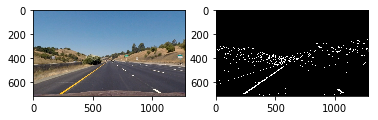

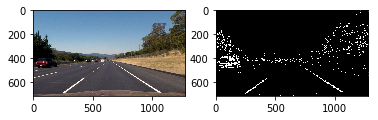

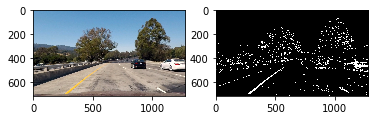

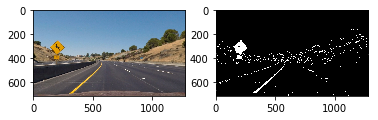

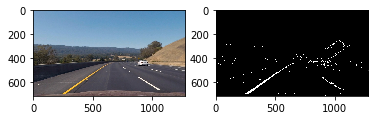

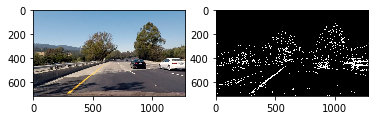

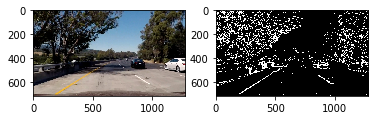

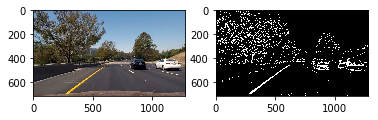

In [65]:
binary_images = []
for image in images:
    binary_image = cvt_binary_img(image)
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(image)
    #plt.show()
    fig.add_subplot(1,2,2)
    plt.imshow(binary_image, cmap='gray')
    plt.show()
    binary_images.append(binary_image)

### 3. Perspective Transform

After we get a binary image that contains lane lines, we gonna perform a perspective transform to the image and it will be rectified to a "birds-eye view".

A straight road is choosed to verify the transformation.

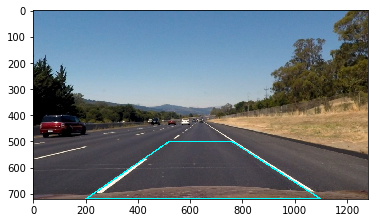

In [130]:
image = images[1]

copy = np.copy(image)

xLen = copy.shape[1]
yLen = copy.shape[0]
ht = 500
#src = np.float32([[yLen, offset1], [400, offset2], [400, xLen-offset2], [yLen, xLen-offset1]])
src = np.float32([[200, yLen], [520, ht], [760, ht], [xLen-180, yLen]])
lines = cv2.polylines(copy, np.int32([src]), True, (0, 255, 255), 3)
plt.imshow(lines)
plt.show()

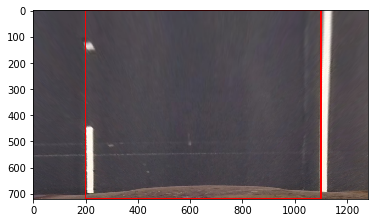

In [131]:
dst = np.float32([[200, yLen], [200, 0], [xLen-180, 0], [xLen-180, yLen]])

M = cv2.getPerspectiveTransform(src, dst)
image_size = (image.shape[1], image.shape[0])
warped = cv2.warpPerspective(image, M, image_size, cv2.INTER_LINEAR)

# Draw lines
lines = cv2.polylines(warped, np.int32([dst]), True, (255, 0, 0), 3)
plt.imshow(lines)
plt.show()

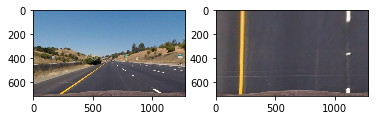

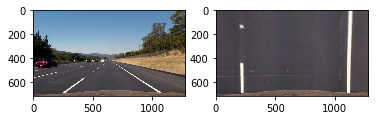

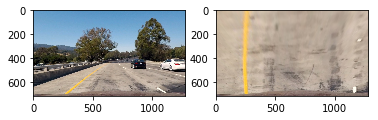

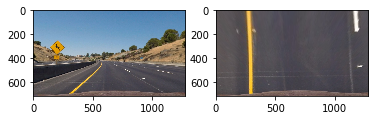

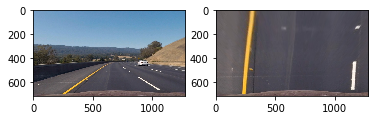

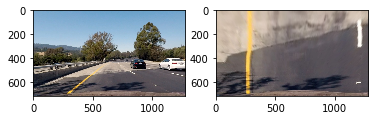

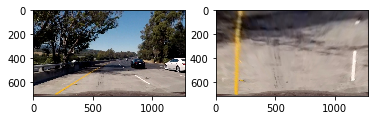

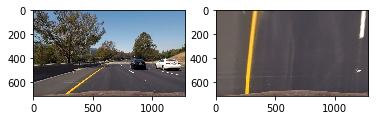

In [129]:
warp_images = []
for image in images:
    image_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, M, image_size, cv2.INTER_LINEAR)
    warp_images.append(warped)
    
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(image)
    fig.add_subplot(1,2,2)
    plt.imshow(warped)
    plt.show()